In [1]:
# Readin Excel file that contains DPRD table from access db

import pandas as pd
df = pd.read_excel('DPRD.xlsx')

In [2]:
# Taking only the columns we need
data=df[['DATE','S_GAS']]

# transferring all the values to mounthly production of gas for the GTFT groupe
### we will do that by doing the next steps:
* WE calculate the daily producyion of all the GTFT groupe by summing up the observations of all the wells.
* We calculate the mean of the production of every month(grouping values by month)

In [3]:
# Get the dailt production if the GTFG Group
daily_prod = data.groupby(data['DATE'])['S_GAS'].sum() 
daily_prod

DATE
1999-03-05    0.000000
1999-03-06    0.887902
1999-03-07    0.908207
1999-03-08    1.405204
1999-03-09    4.249948
                ...   
2022-04-26    6.585172
2022-04-27    6.516031
2022-04-28    6.739515
2022-04-29    7.249629
2022-04-30    7.665625
Name: S_GAS, Length: 8377, dtype: float64

In [4]:
# Calculating the production mean of every month
daily_gas_prod= pd.DataFrame({'date':daily_prod.index,'s_gas':daily_prod.values})
daily_gas_prod['year']=daily_gas_prod['date'].dt.year
daily_gas_prod['month']=daily_gas_prod['date'].dt.month
mothly_prod = daily_gas_prod.groupby(['year','month'])['s_gas'].mean()

In [5]:
mothly_prod

year  month
1999  3         4.350048
      4         8.215190
      5         9.664029
      6         6.136187
      7        12.144943
                 ...    
2021  12        5.084286
2022  1         6.879660
      2         6.322890
      3         6.610888
      4         6.454660
Name: s_gas, Length: 278, dtype: float64

In [6]:
# Creating dates for the resulted dataset
yrls=[1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
mnls=[1,2,3,4,5,6,7,8,9,10,11,12]
yrmnls=[]
for i in yrls:
    for j in mnls:
        if (i==1999 and j < 3) or (i==2022 and j > 4):
            pass
        else :
            yrmnls.append(str(i)+'-'+str(j))
len(yrmnls)

278

In [7]:
# Assigning a date to every row in the resulted dataset
mothly_prod = pd.DataFrame({'mounthly_prod': mothly_prod.values})
yrmndf = pd.DataFrame({'date': yrmnls})
mothly_prod['date'] =  yrmndf
mothly_prod['date'] = pd.to_datetime(mothly_prod['date'])
mothly_prod = mothly_prod.set_index('date')

In [13]:
mothly_prod = mothly_prod[mothly_prod.index >= '2014-01-01']

<Axes: xlabel='date'>

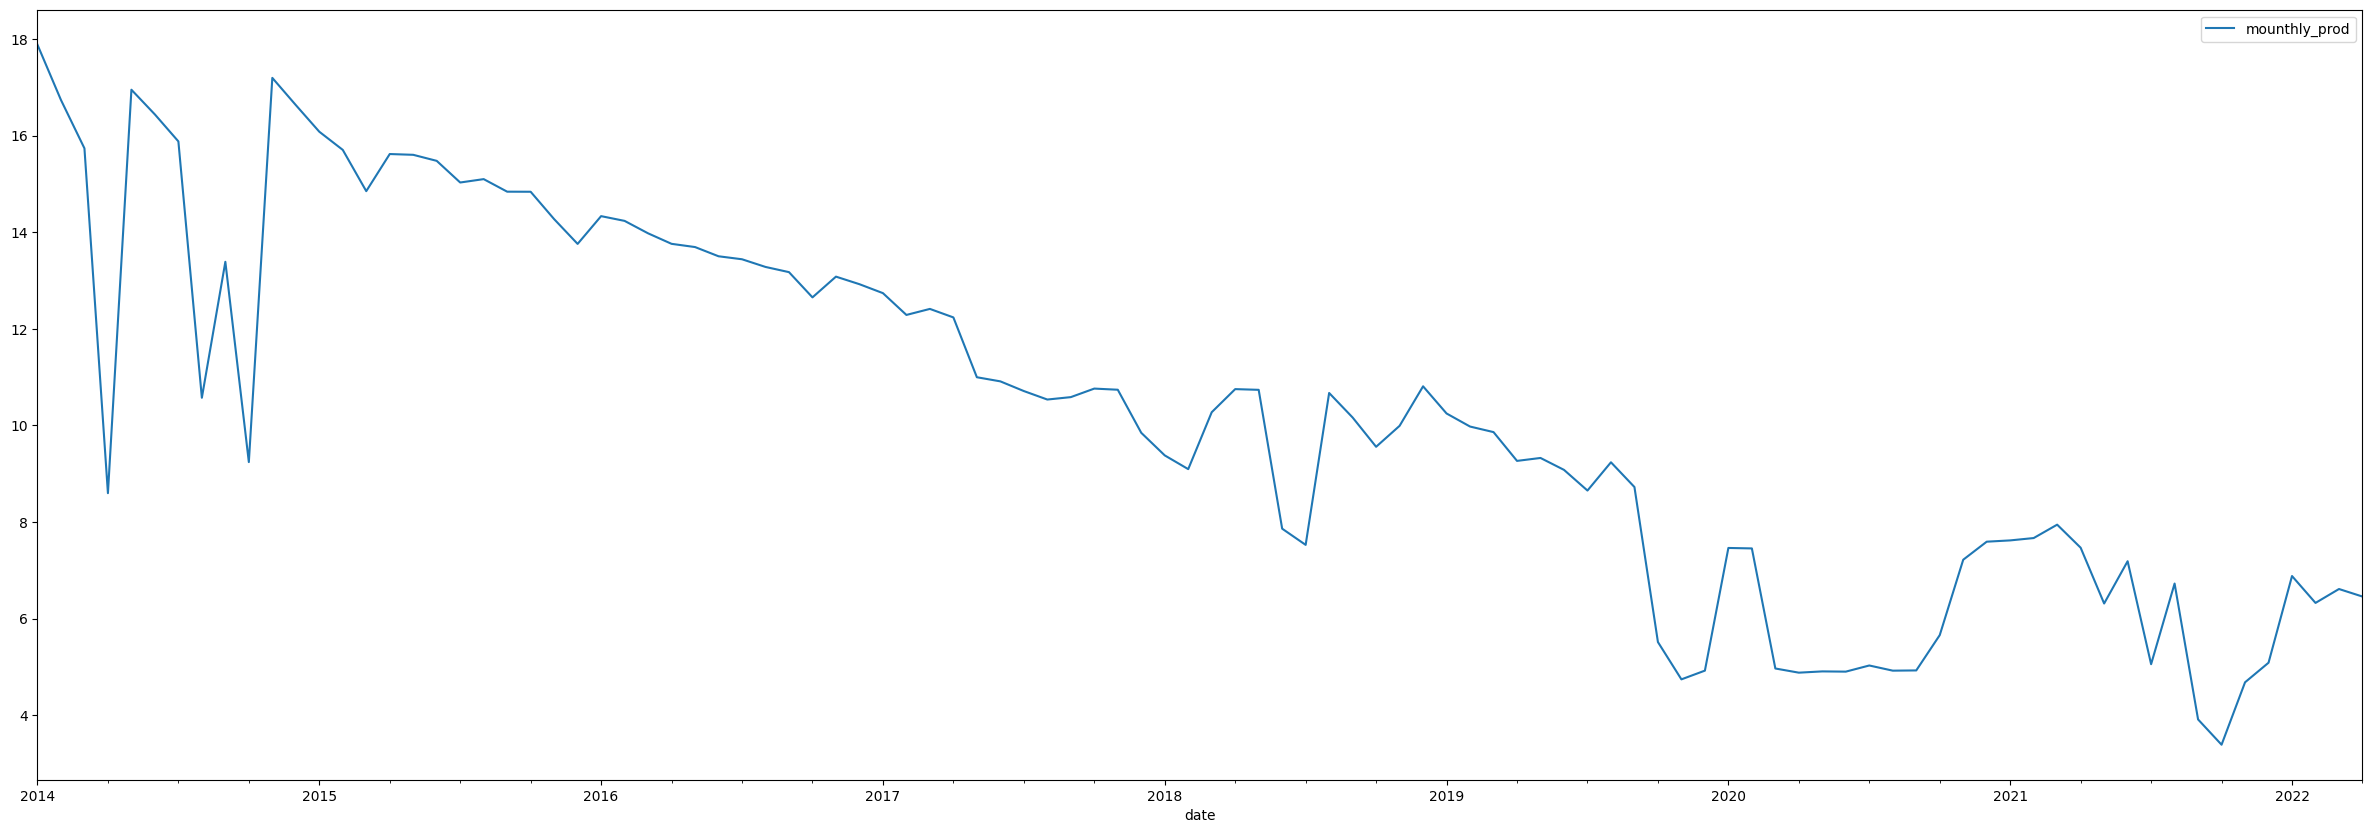

In [14]:
# Plotting the monthly production of gas of GTFG group
mothly_prod.plot(figsize=(30,10))

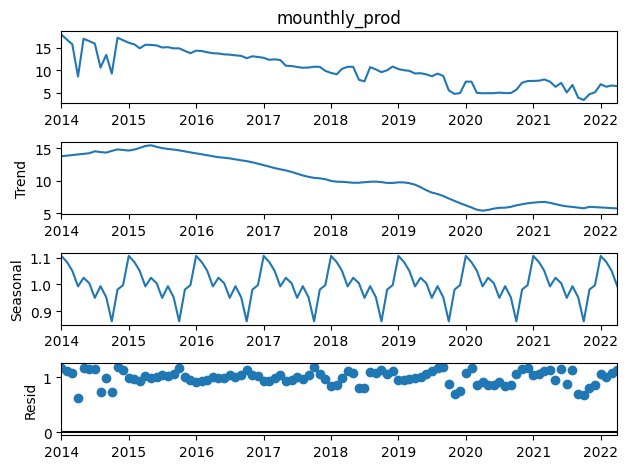

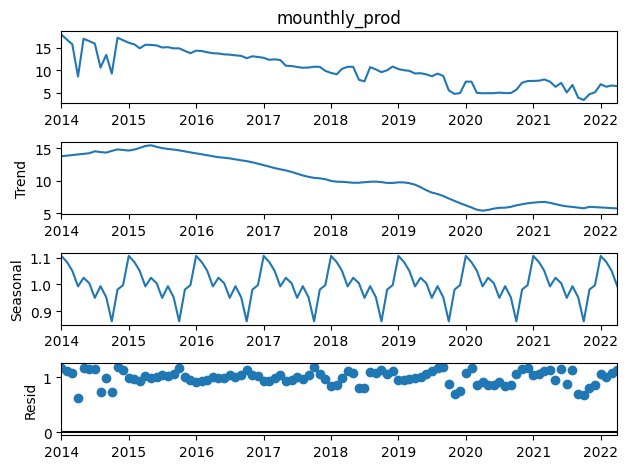

In [15]:
# decomposition of the time serie to (trend, seasonal data, residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
series = mothly_prod['mounthly_prod']
result = seasonal_decompose(series, model='multiplicative',extrapolate_trend='freq')
result.plot()

<Axes: xlabel='date'>

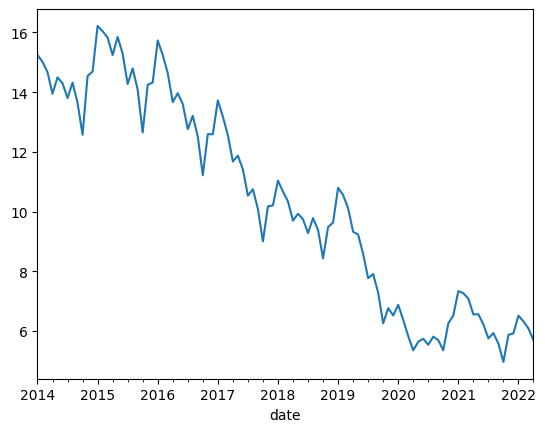

In [16]:
estimation = result.seasonal*result.trend
estimation.plot()

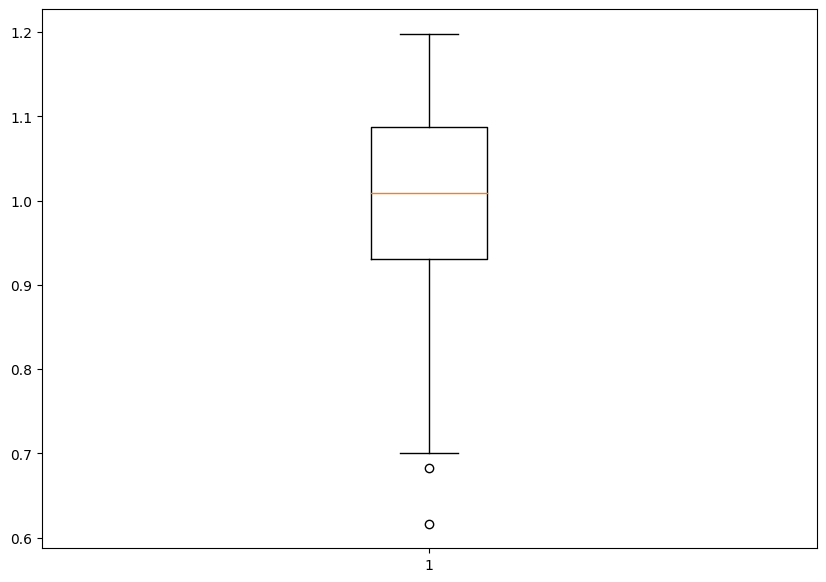

In [17]:
# Import libraries
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))

# Creating plot for resudials
plt.boxplot(result.resid)
 
# show plot
plt.show()

c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


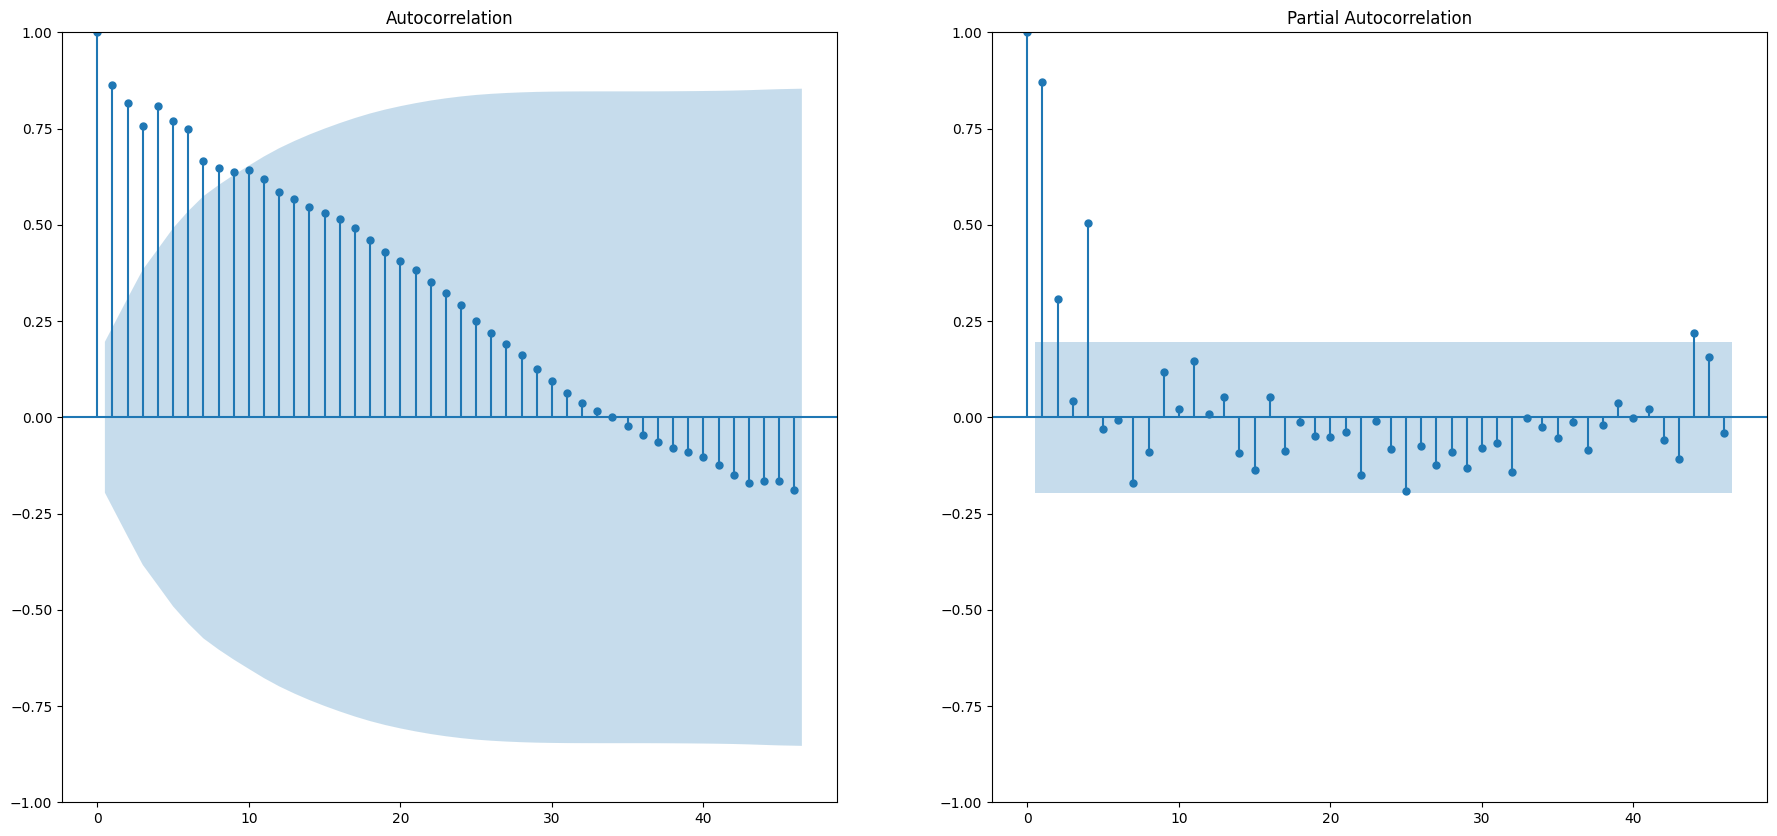

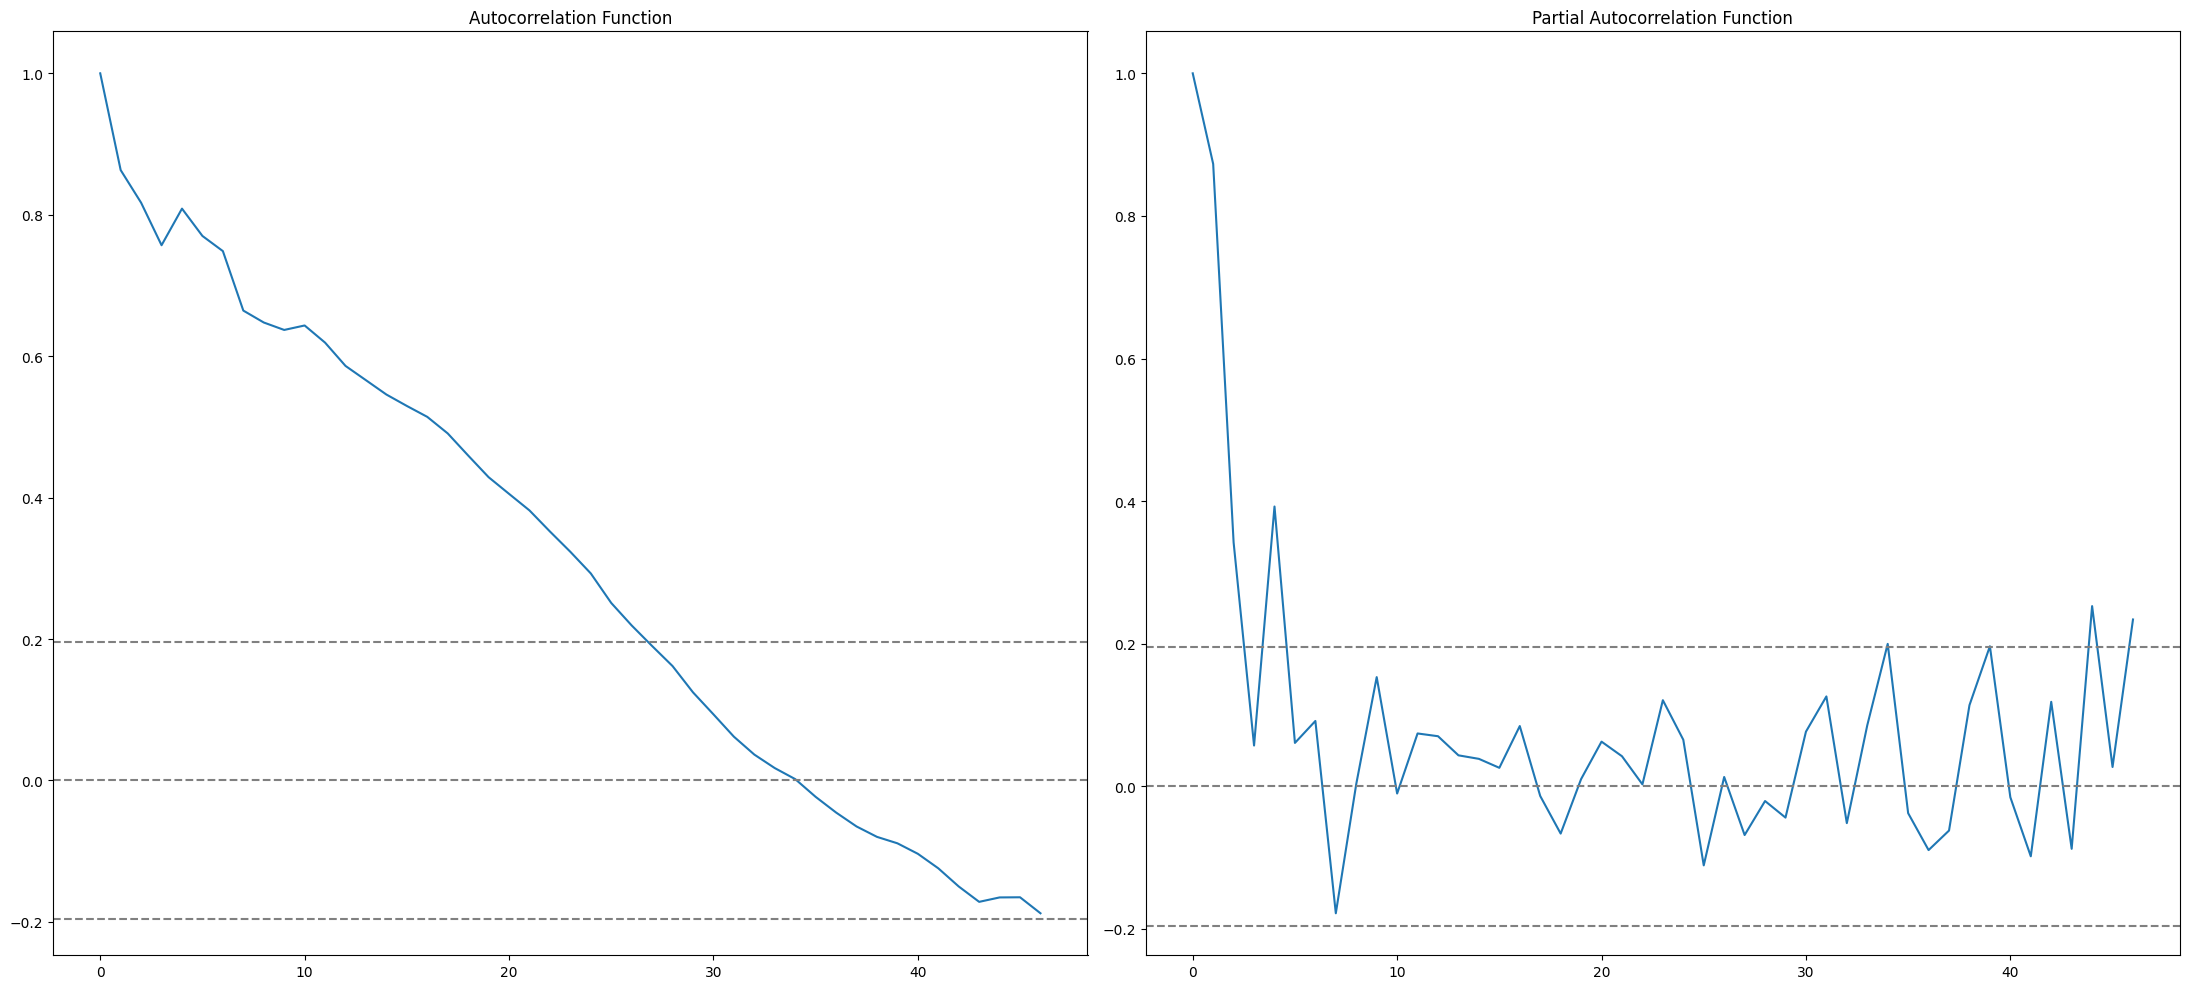

In [18]:
# ACF and PACF 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


lag_acf = acf(mothly_prod, nlags=46)
lag_pacf = pacf(mothly_prod, nlags=46, method='ols')


fig, axes = plt.subplots(1,2,figsize=(22,10), dpi= 100)
plot_acf(mothly_prod.values.tolist(), lags=46, ax=axes[0])
plot_pacf(mothly_prod.values.tolist(), lags=46, ax=axes[1])


# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mothly_prod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mothly_prod)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mothly_prod)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mothly_prod)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

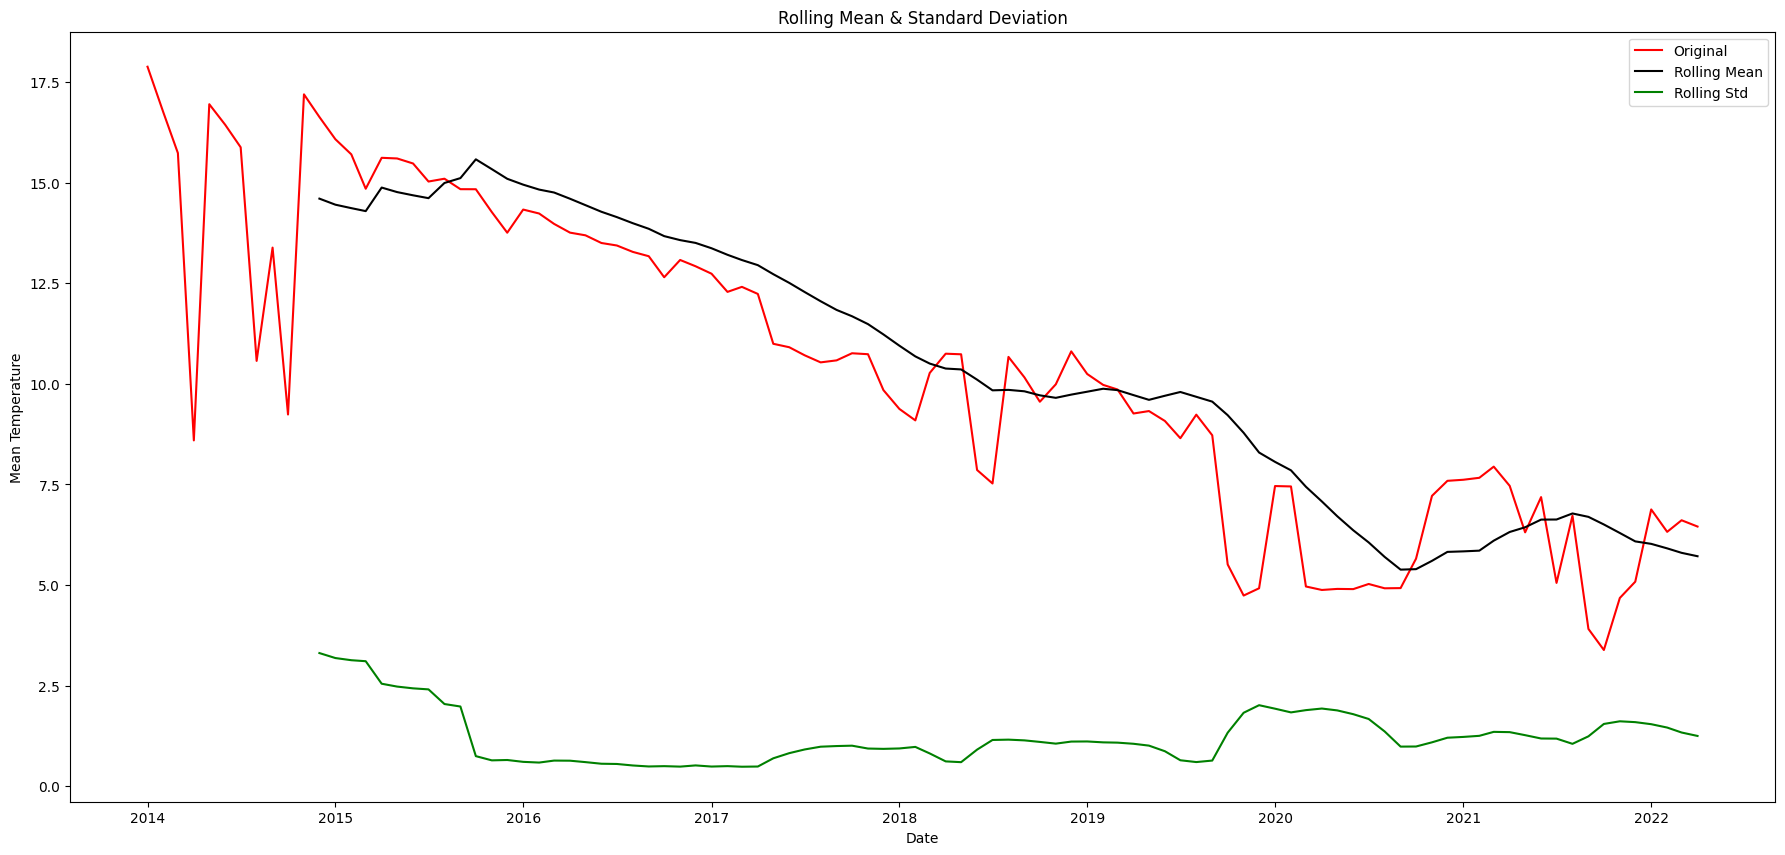

In [19]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(mothly_prod)

In [20]:
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts,maxlag=5):
    # Dickey-Fuller test
    result = adfuller(ts,maxlag)
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
check_adfuller(mothly_prod,maxlag=12)

Test statistic:  -1.106569771420008
p-value:  0.7124448575044143
Critical Values: {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}


# Remove the outliers

In [21]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers
outliers = find_outliers_IQR(result.resid)

In [22]:
rolmean = mothly_prod.rolling(window=12).mean()
for i in outliers[6:].index.values:
    mothly_prod.loc[i].at['mounthly_prod'] = rolmean.loc[i].at['mounthly_prod']

In [23]:
for i in outliers[6:].index.values:
    print(i)
    print(mothly_prod.loc[i].at['mounthly_prod'],'----', rolmean.loc[i].at['mounthly_prod'])

# Stasionarisation de la series temporelles
- Differentiation.
- Getting rid of colatility changes.

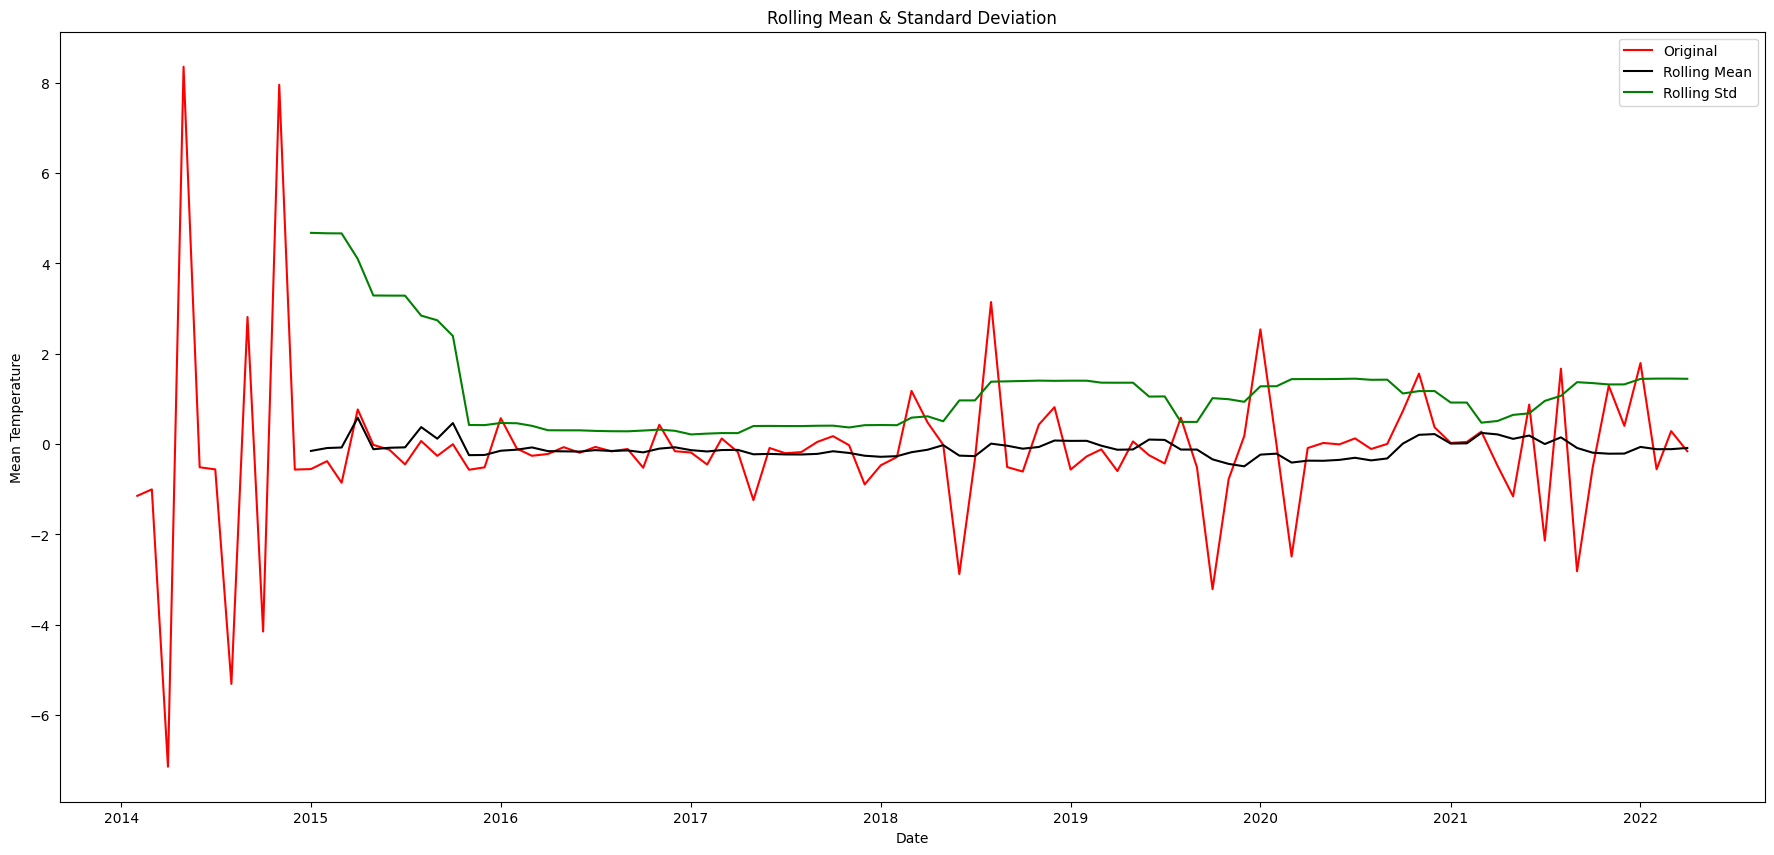

In [24]:
#diffrentiating
mothly_prod_diff = mothly_prod - mothly_prod.shift()
# check stationary: mean, variance(std)and adfuller test
check_mean_std(mothly_prod_diff)

In [25]:
# Volatility elimination

#calculating every year standard deviation
stds= mothly_prod_diff
stds['year']=mothly_prod_diff.index
year_std = stds.groupby(stds['year'].dt.year).std()
novol_prod=[]

# deviding the result of each month by the std of it's year
for i in range(1,len(stds)):
    print(i)
    j=0
    while j < len(year_std):
        print(j)
        if stds.iloc[i,1].year == year_std.index[j] :
            novol_prod.append(stds.iloc[i,0] / year_std.iloc[j,0])
        j=j+1
mothly_prod_novol = pd.DataFrame({'s_gas':novol_prod,'date':stds['year'][1:]}).set_index('date')

1
0
1
2
3
4
5
6
7
8
2
0
1
2
3
4
5
6
7
8
3
0
1
2
3
4
5
6
7
8
4
0
1
2
3
4
5
6
7
8
5
0
1
2
3
4
5
6
7
8
6
0
1
2
3
4
5
6
7
8
7
0
1
2
3
4
5
6
7
8
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
10
0
1
2
3
4
5
6
7
8
11
0
1
2
3
4
5
6
7
8
12
0
1
2
3
4
5
6
7
8
13
0
1
2
3
4
5
6
7
8
14
0
1
2
3
4
5
6
7
8
15
0
1
2
3
4
5
6
7
8
16
0
1
2
3
4
5
6
7
8
17
0
1
2
3
4
5
6
7
8
18
0
1
2
3
4
5
6
7
8
19
0
1
2
3
4
5
6
7
8
20
0
1
2
3
4
5
6
7
8
21
0
1
2
3
4
5
6
7
8
22
0
1
2
3
4
5
6
7
8
23
0
1
2
3
4
5
6
7
8
24
0
1
2
3
4
5
6
7
8
25
0
1
2
3
4
5
6
7
8
26
0
1
2
3
4
5
6
7
8
27
0
1
2
3
4
5
6
7
8
28
0
1
2
3
4
5
6
7
8
29
0
1
2
3
4
5
6
7
8
30
0
1
2
3
4
5
6
7
8
31
0
1
2
3
4
5
6
7
8
32
0
1
2
3
4
5
6
7
8
33
0
1
2
3
4
5
6
7
8
34
0
1
2
3
4
5
6
7
8
35
0
1
2
3
4
5
6
7
8
36
0
1
2
3
4
5
6
7
8
37
0
1
2
3
4
5
6
7
8
38
0
1
2
3
4
5
6
7
8
39
0
1
2
3
4
5
6
7
8
40
0
1
2
3
4
5
6
7
8
41
0
1
2
3
4
5
6
7
8
42
0
1
2
3
4
5
6
7
8
43
0
1
2
3
4
5
6
7
8
44
0
1
2
3
4
5
6
7
8
45
0
1
2
3
4
5
6
7
8
46
0
1
2
3
4
5
6
7
8
47
0
1
2
3
4
5
6
7
8
48
0
1
2
3
4
5
6
7
8
4

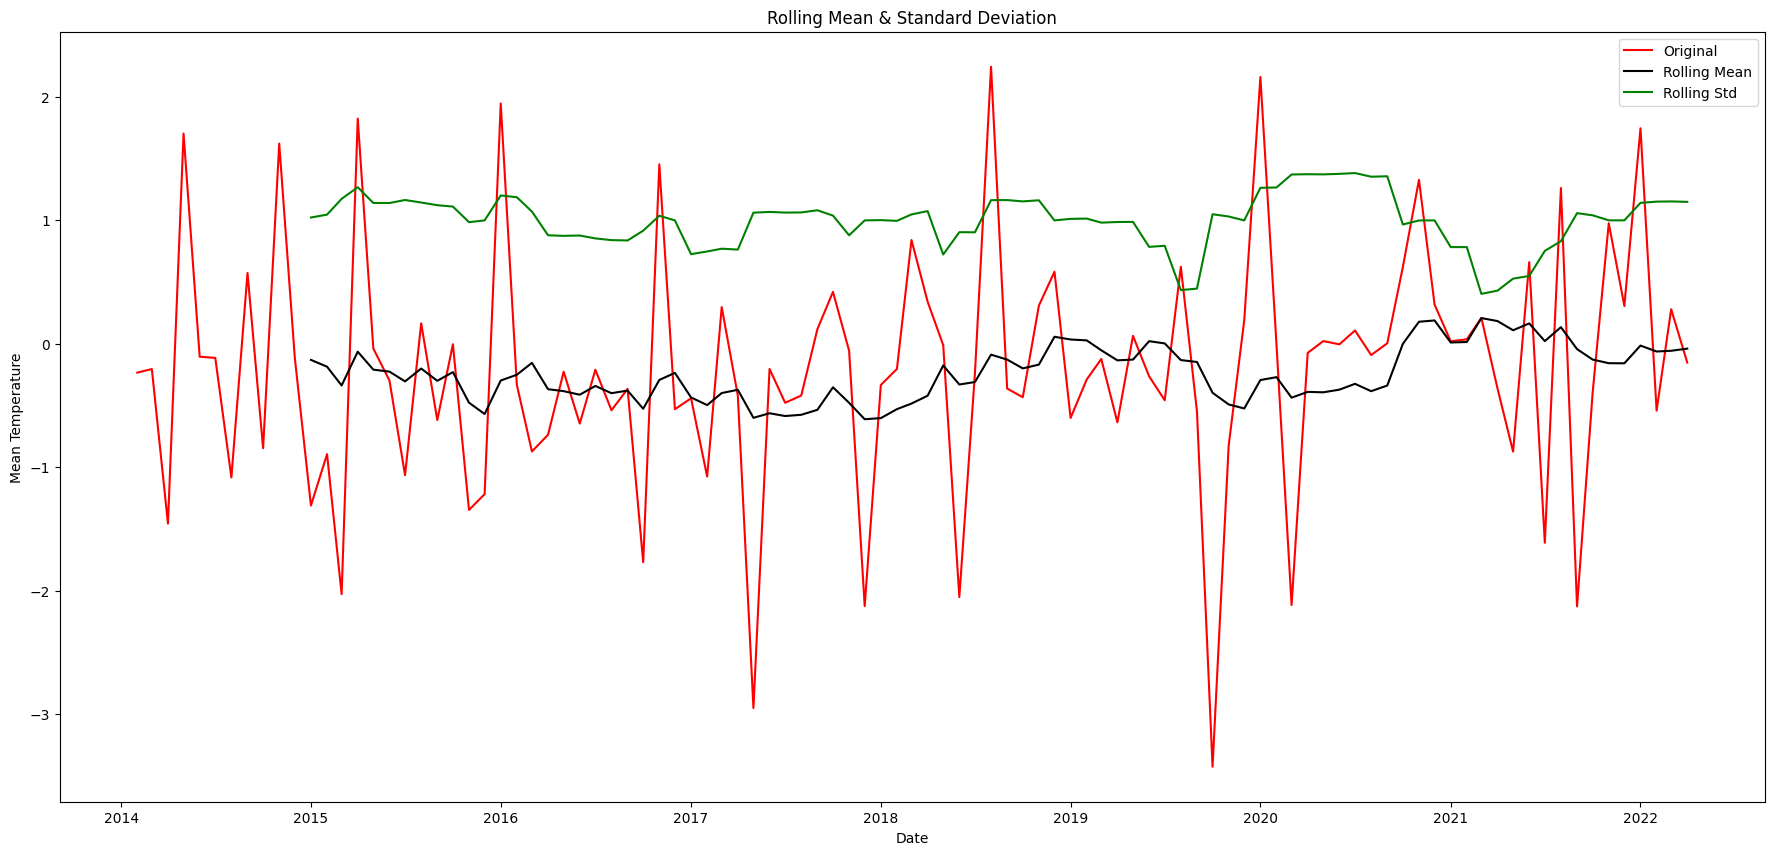

In [26]:
check_mean_std(mothly_prod_novol)

In [27]:
check_adfuller(mothly_prod_novol['s_gas'],maxlag=12)

Test statistic:  -7.861597156116847
p-value:  5.266316926350077e-12
Critical Values: {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


In [28]:
# dividing data into training and test
train_prod = mothly_prod[:-12]
test_prod = mothly_prod[-12:]
train_prod

,mounthly_prod
date,
2014-01-01,17.882465
2014-02-01,16.738203
2014-03-01,15.736567
2014-04-01,8.595606
2014-05-01,16.950685
...,...
2020-12-01,7.590960
2021-01-01,7.617564
2021-02-01,7.666199


c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


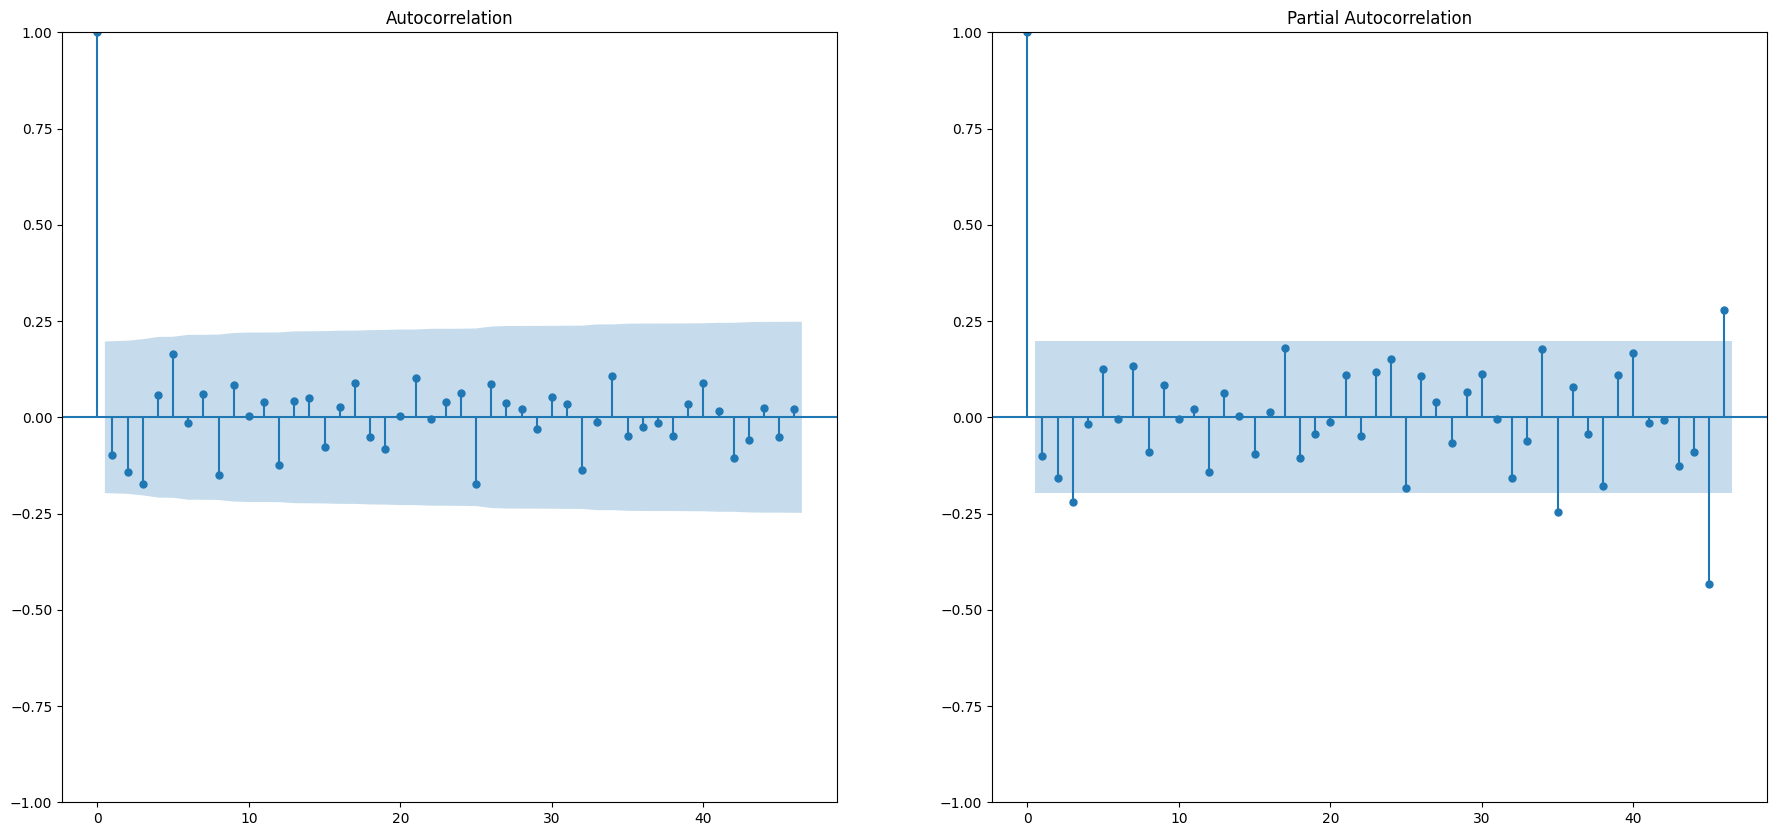

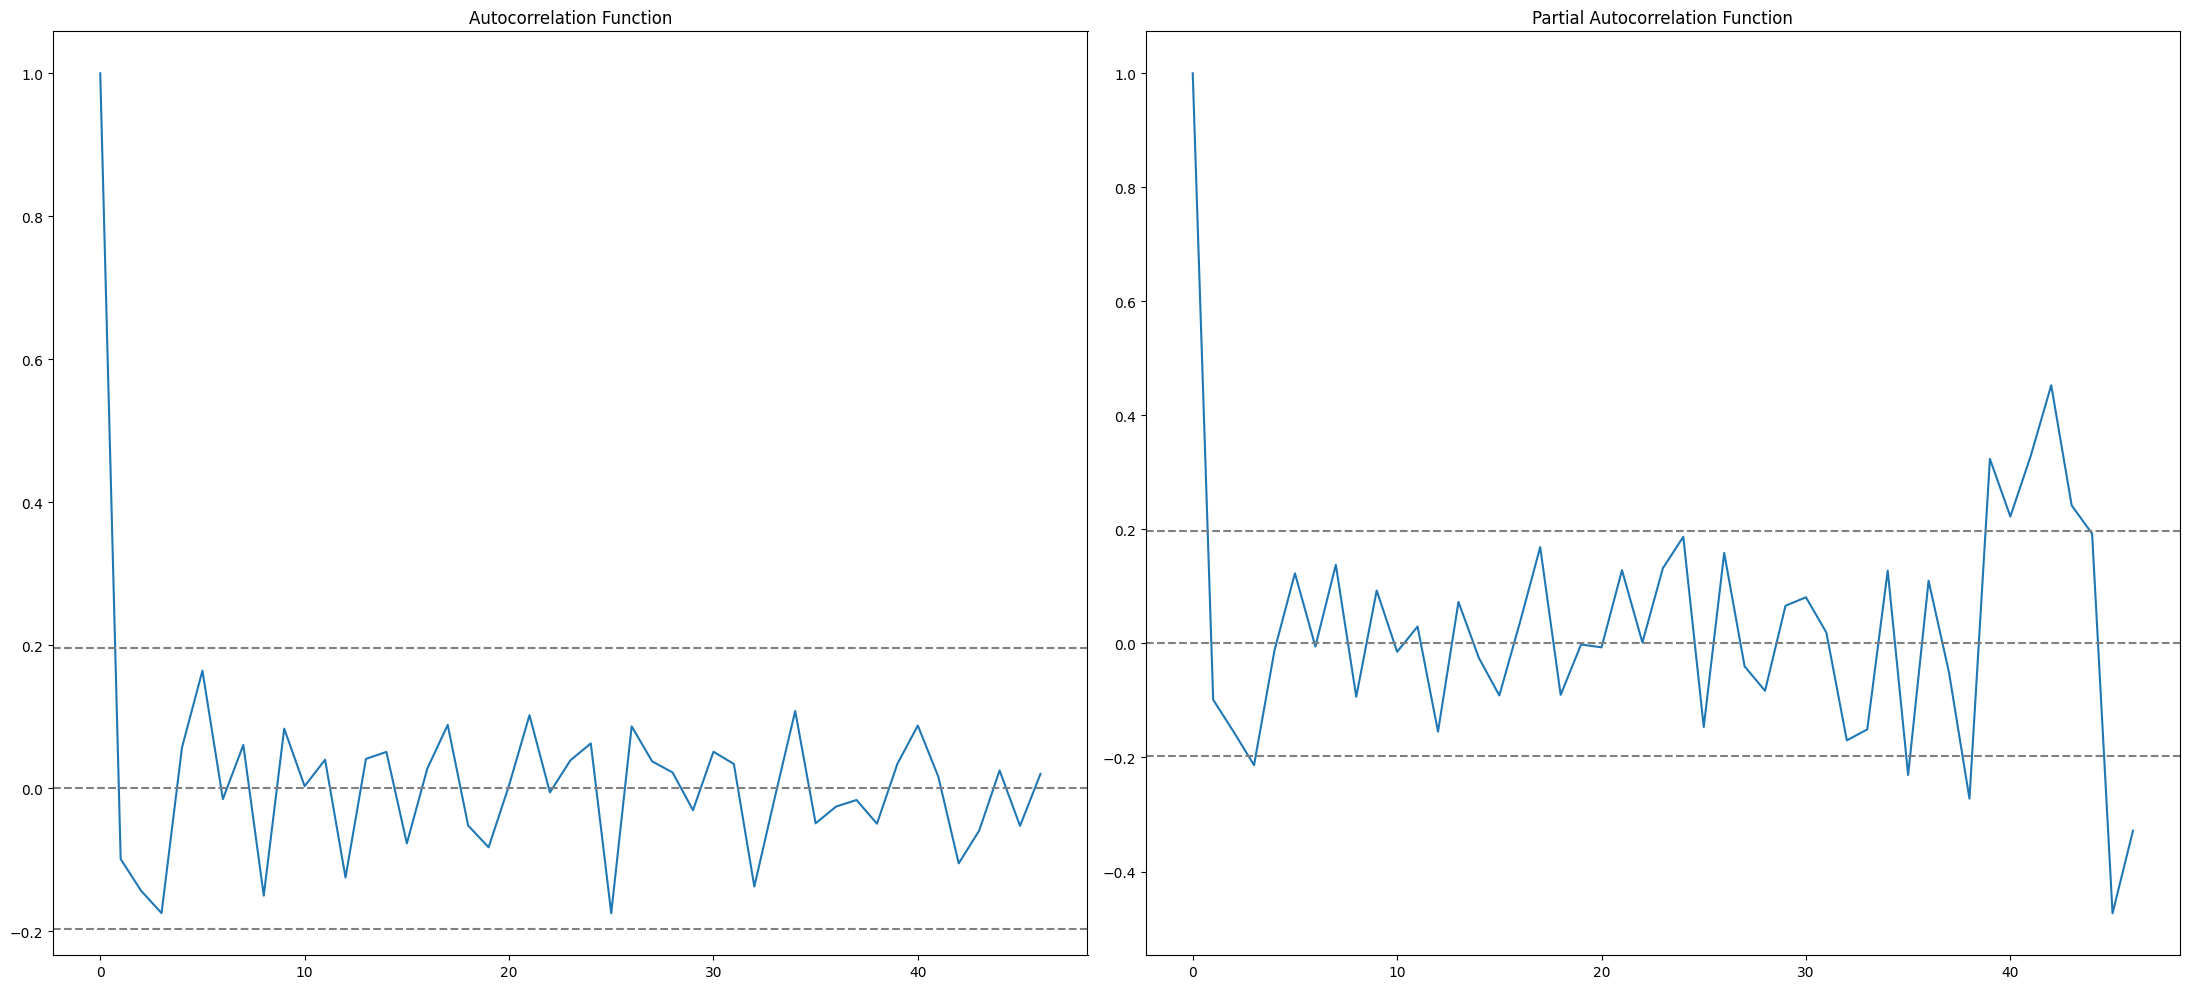

In [29]:
# ACF and PACF 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


lag_acf = acf(mothly_prod_novol, nlags=46)
lag_pacf = pacf(mothly_prod_novol, nlags=46, method='ols')


fig, axes = plt.subplots(1,2,figsize=(22,10), dpi= 100)
plot_acf(mothly_prod_novol.values.tolist(), lags=46, ax=axes[0])
plot_pacf(mothly_prod_novol.values.tolist(), lags=46, ax=axes[1])


# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mothly_prod_novol)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mothly_prod_novol)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(mothly_prod_novol)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(mothly_prod_novol)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [30]:
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_prod, order=(1,1,1),seasonal_order=(1,1,1,12)) # (ARMA) = (1,1,1)
model_fit = model.fit()
model_fit.aic
results=[]
for j in range(4):
  for k in range(2):
    for l in range(4):
      for m in range(3):
        model = ARIMA(train_prod, order=(j,1,k),seasonal_order=(m,1,l,12)) # (ARMA) = (1,1,1)
        model_fit = model.fit()
        results.append((model_fit.aic,(j,1,k),(m,1,l,12)))
print(results)

c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Program

[(335.00237602921067, (0, 1, 0), (0, 1, 0, 12)), (330.3410479860594, (0, 1, 0), (1, 1, 0, 12)), (331.71951450377156, (0, 1, 0), (2, 1, 0, 12)), (329.9740969221182, (0, 1, 0), (0, 1, 1, 12)), (331.6853073195172, (0, 1, 0), (1, 1, 1, 12)), (333.6981420401891, (0, 1, 0), (2, 1, 1, 12)), (331.78234757820803, (0, 1, 0), (0, 1, 2, 12)), (333.6696981980439, (0, 1, 0), (1, 1, 2, 12)), (335.6487951144709, (0, 1, 0), (2, 1, 2, 12)), (333.33498270918335, (0, 1, 0), (0, 1, 3, 12)), (335.1487142646635, (0, 1, 0), (1, 1, 3, 12)), (337.06367347999696, (0, 1, 0), (2, 1, 3, 12)), (323.5006145789025, (0, 1, 1), (0, 1, 0, 12)), (315.0304941640263, (0, 1, 1), (1, 1, 0, 12)), (315.9125736882175, (0, 1, 1), (2, 1, 0, 12)), (314.7513899422888, (0, 1, 1), (0, 1, 1, 12)), (315.93343348624546, (0, 1, 1), (1, 1, 1, 12)), (317.903427538909, (0, 1, 1), (2, 1, 1, 12)), (316.3102187982108, (0, 1, 1), (0, 1, 2, 12)), (317.90551804789976, (0, 1, 1), (1, 1, 2, 12)), (319.59266962587395, (0, 1, 1), (2, 1, 2, 12)), (316.

In [31]:
# Getting the model with the minimal value for AIC 
mi=min(results)
mi

(303.7643691825664, (3, 1, 0), (0, 1, 1, 12))

In [32]:
# Using SARIMA(2,1,0,0,1,1,12)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_prod, order=(3, 1, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()

c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kyorakuna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### 1 LAg, 12 steps

In [33]:
mothly_prod_pred=model_fit.forecast(12)

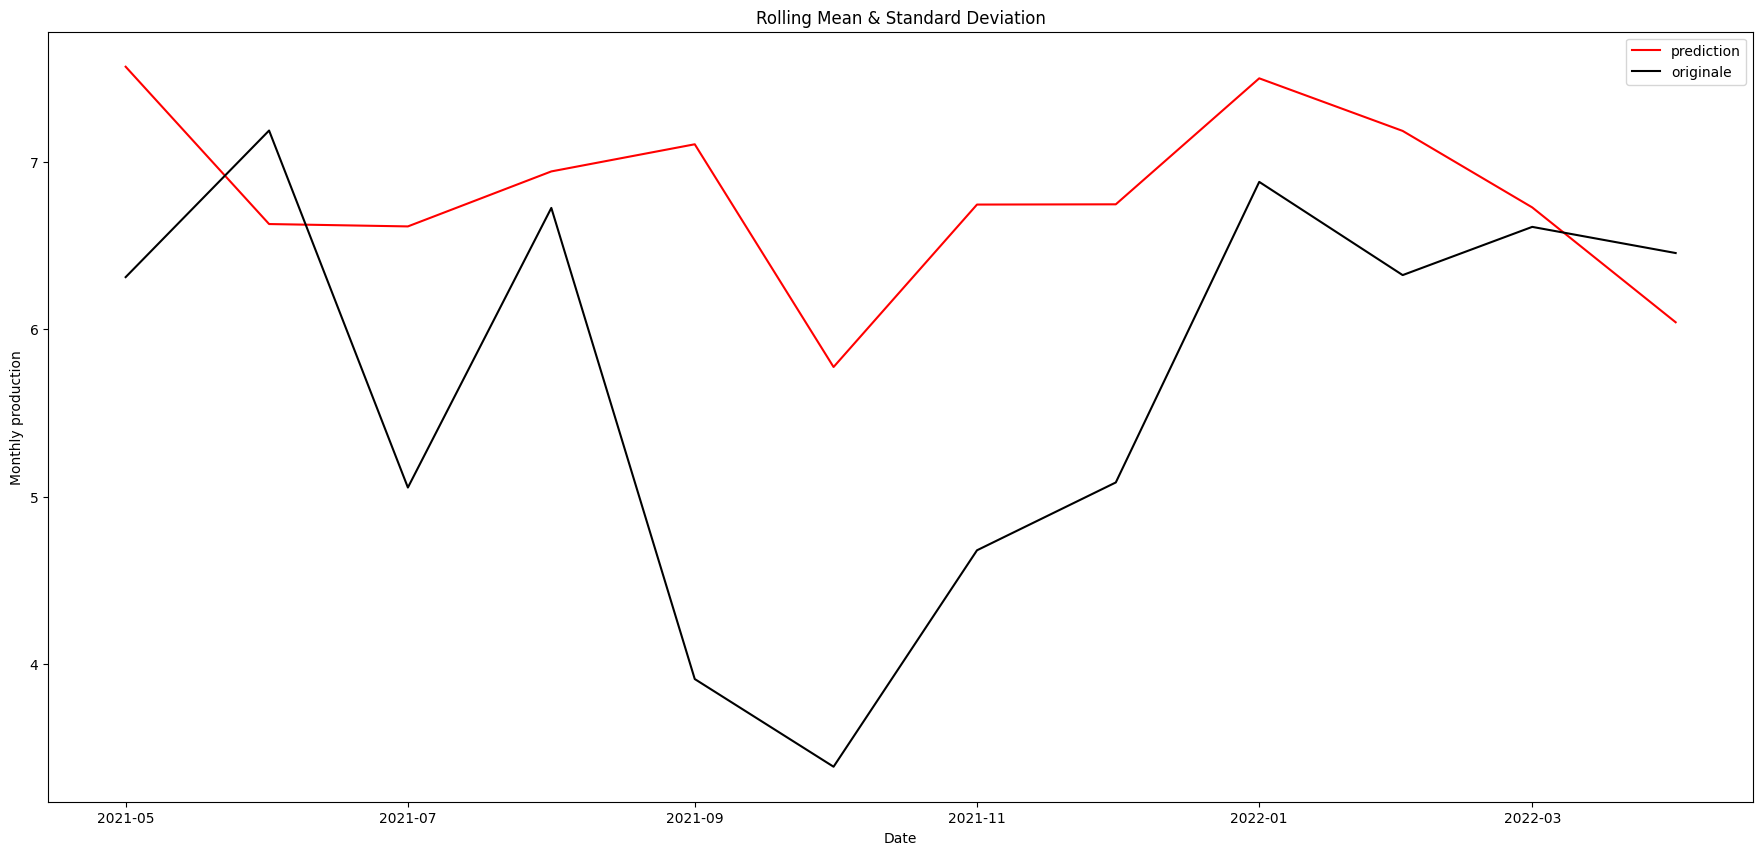

In [34]:
plt.figure(figsize=(22,10))   
plt.plot(mothly_prod_pred, color='red',label='prediction')
plt.plot(test_prod, color='black', label='originale')
plt.xlabel("Date")
plt.ylabel("Monthly production")
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [35]:
def forecast_accuracy(forecast, actual):    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    print("Mean Absolute Percent Error: ", (np.mean(np.abs((actual-forecast) / actual))))
    me = np.mean(forecast - actual)             # ME
    print("Mean Error: ", (np.mean(forecast-actual)))
    mae = np.mean(np.abs(forecast - actual))    # MAE
    print("Mean Absolute Error: ", (np.mean(np.abs((forecast-actual)))))
    mpe = np.mean((forecast - actual)/actual)   # MPE
    print("Mean Percent Error: ", (np.mean((forecast-actual)/actual)))
    rmse = (np.mean((forecast - actual)**2))**0.5  # RMSE
    print("Root Mean Square Error: ", np.mean((forecast - actual)**2)**.5)    
    return
print(forecast_accuracy(np.array(mothly_prod),np.array(mothly_prod_pred)))

Mean Absolute Percent Error:  0.634232903238166
Mean Error:  3.589870913303295
Mean Absolute Error:  4.263236499468481
Mean Percent Error:  0.5368853129518977
Root Mean Square Error:  5.240844133054691
None
